## Beat COVID-19 with data analysis

### Simulation of the evolution of covid-19 using SEIR model

We divide a population into 4 groups: S, E, I and R, which is the number of susceptible, exposed, infectious and recovered individuals at time t. Ordinary differential equations (ODEs) for this SEIR model are given by:

$$\frac{dS}{dt} = - \beta SI$$
$$\frac{dE}{dt} = \beta SI - \alpha E$$
$$\frac{dI}{dt} = \alpha E - \gamma I - \delta I$$
$$\frac{dR}{dt} = \gamma I$$

Please find more details in this arrticle: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118/ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace
import pandas as pd

def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, delta = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1] - delta*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

In [2]:
def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, delta, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1] - delta*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

In [3]:
def seir_delay_soc_dist(init_vals, params, t, Delay_quarantine= 35):
    param1 = params[:-1]
    results[:Delay_quarantine,:] = base_seir_model(init_vals, param1, t[:Delay_quarantine])
    results[Delay_quarantine:,:] = seir_model_with_soc_dist(results[Delay_quarantine-1,:], params, t[Delay_quarantine:])
    return results

Aged group will need more hospital beds and other healthcare resources. Strengthen the social distancing for aged people will largely affect the death rate and the pressure on healthcare system.

C:\Users\chrji\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\chrji\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


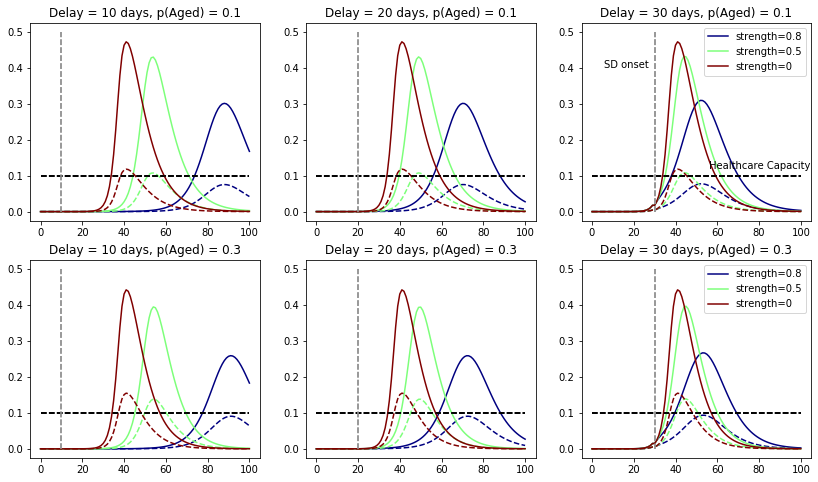

In [14]:
age_group = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80+']
age_death_rate = [0, 0.002, 0.002, 0.002, 0.004, 0.013, 0.036, 0.08, 0.18]
age_hospitalized = [0.18, 0.1, 0.08, 0.18, 0.18, 0.32, 0.4, 0.6, 0.8]

#age_distribution = 
disease_death = {'Cardiovascular': 0.132, 'Diabetes':0.09, 'Chronic respiratory':0.08,
                 'Hypertension':0.084, 'Cancer': 0.076,'no pre-existing conditions': 0.009}

t_max = 100
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 8000000  # population
M = 1
alpha = 0.2 # 1/incubation period, 5.1 days (95% CI, 4.5 to 5.8 days),
beta = 3 # spreading rate 
gamma = 0.1 # recovery rate

risky_group_ratio = 0.1 # change locally
delta = 0.01 * (1-risky_group_ratio) + risky_group_ratio * 0.1 # death rate, 0.01 for younger group, but over 0.1 for eldly group
HealthCare_need = 0.2 * (1-risky_group_ratio) + risky_group_ratio * 0.7

Delay_quarantine = 10

results = np.zeros((101, 4))
fig = plt.figure(figsize = (14, 8))  

number_of_lines = 3
cm_subsection = linspace(0, 1, number_of_lines) 
colors = [plt.cm.jet(x) for x in cm_subsection]

ii = 0
for rho in [0.2, 0.5, 1]:
    params = alpha, beta, gamma, delta, rho  
    num=1
    for Delay_quarantine in [10, 20, 30]:
        init_vals = 1 - M/N, M/N, 0, 0    
        # Run simulation    
        plt.subplot(2, 3, num)
        results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)          
        #print(np.argmax(results[:,2]))
        all_case =  (results[:,2] + results[:,3])
        plt.plot(results[:,2], color = colors[ii], label =  'strength=' + str(1-rho) ) 
        plt.plot(results[:,2]*HealthCare_need, color = colors[ii], linestyle = '--') 
        plt.plot([0, 100],[0.1, 0.1], 'k--')
        num += 1
        plt.title('Delay = {} days, p(Aged) = {}'.format(Delay_quarantine,risky_group_ratio))
        plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.5], '--', color = [0.6, 0.6, 0.6])
        
        #plt.plot(xx_delay, Hubei,color = colors[ii], linestyle = '--')  
    ii += 1
plt.text(56, 0.12, 'Healthcare Capacity')    
plt.text(6, 0.4, 'SD onset')    
plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.5],'--', color = [0.6, 0.6, 0.6]) 
plt.legend()


risky_group_ratio = 0.3 # change locally
delta = 0.01 * (1-risky_group_ratio) + risky_group_ratio * 0.1 # death rate, 0.01 for younger group, but over 0.1 for eldly group
HealthCare_need = 0.2 * (1-risky_group_ratio) + risky_group_ratio * 0.7

Delay_quarantine = 10
ii = 0
for rho in [0.2, 0.5, 1]:
    params = alpha, beta, gamma, delta, rho 
    num = 1
    for Delay_quarantine in [10, 20, 30]:
        plt.subplot(2, 3, 3 + num)
        init_vals = 1 - M/N, M/N, 0, 0
        # Run simulation  
        results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)
        #print(np.argmax(results[:,2]))
        plt.plot(results[:,2] ,color = colors[ii], label = 'strength=' + str(1-rho)) 
        plt.plot(results[:,2]* HealthCare_need,color = colors[ii], linestyle = '--') 
        plt.plot([0, 100],[0.1, 0.1], 'k--')
        plt.title('Delay = {} days, p(Aged) = {}'.format(Delay_quarantine,risky_group_ratio))
        plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.5], '--', color = [0.6, 0.6, 0.6])
        num += 1
    ii += 1
plt.legend()

#plt.title('Social Distancing at {} th day'.format(Delay_quarantine))

We can see that the time to start social distancing is really important. If you start to do social distancing 30 days after covid-19 emerges, the effect can be much weaker compared with the results of 10-day delay. By changing the population size N, you can find that this delay-effect is even more obvious in smaller populations.

### Model fitting 
This project uses China's data to fit the main parameters first, since most cases in China has been closed, so we have enough data to trace the whole process of the virus spreading. 

China's data are diveded into two parts based on locations: Hubei (the epicenter) and other regions. Since the death rate in Hubei is much higher than other places.

Text(0.5, 1.0, 'China Hubei')

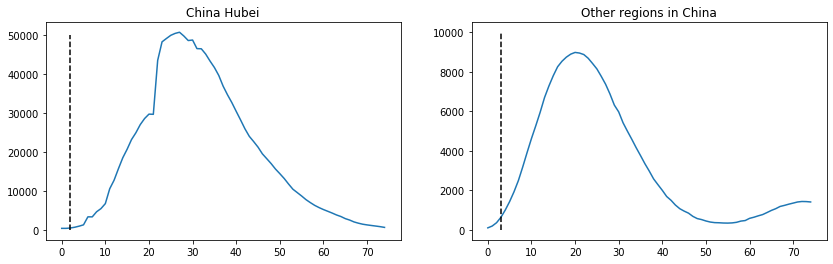

In [17]:
path =  r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\China_Data.csv'
df = pd.read_csv(path,encoding = "ISO-8859-1", error_bad_lines=False)

fig = plt.figure(figsize = (14, 4))  
plt.subplot(122)
Active1 = df.iloc[0, 2:].values - df.iloc[1, 2:].values - df.iloc[2, 2:].values 
plt.plot(Active1)
plt.plot([3, 3], [0, 10000], 'k--')
plt.title('Other regions in China')

Active2 = df.iloc[3, 2:].values - df.iloc[4, 2:].values - df.iloc[5, 2:].values 
plt.subplot(121)
plt.plot(Active2)
plt.plot([2, 2], [0, 50000], 'k--')
plt.title('China Hubei')


Text(0.5, 0, 'Time from onset (days)')

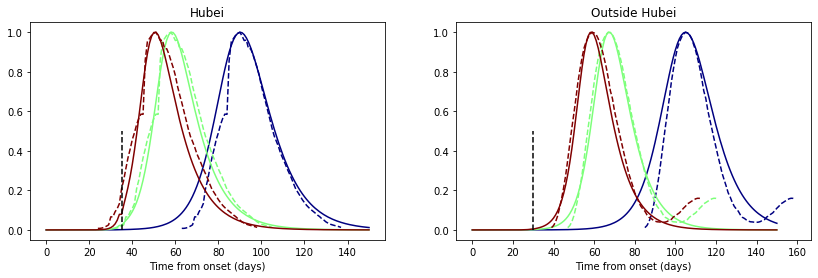

In [24]:
# Define parameters
t_max = 150
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
alpha = 0.2
gamma = 0.05
delta = 0.04
rho = 0.3
Delay_quarantine = 35
N = 58500000
M = 1

results = np.zeros((len(t), 4))
fig = plt.figure(figsize = (14, 4))  
plt.subplot(121)
ii = 0
for beta in [1.5, 2.5, 3]:
    params = alpha, beta, gamma, delta, rho  
    init_vals = 1 - M/N, M/N, 0, 0
    # Run simulation    
    results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)      
    Hubei = Active2/max(Active2)
    peak_loc = np.argmax(results[:,2])    
    peak_loc_hubei = np.argmax(Hubei)
    xx= list(range(len(Hubei)))
    delay1 = peak_loc - peak_loc_hubei
    xx_delay = list(map(lambda x:x + delay1, xx))
    plt.plot(results[:,2]/max(results[:,2]),color = colors[ii], label = str(beta) )  
    plt.plot(xx_delay, Hubei,color = colors[ii], linestyle = '--')  
    ii += 1
plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.5], 'k--') 
#plt.legend()
plt.title('Hubei')
plt.xlabel('Time from onset (days)')

delta = 0.01
N = 1000000000
M = 10
gamma = 0.1
Delay_quarantine = 30
plt.subplot(122)
ii = 0
for beta in [1.5, 2.5, 3]:
    params = alpha, beta, gamma, delta, rho   
    init_vals = 1 - M/N, M/N, 0, 0
    # Run simulation  
    results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)
    peak_loc = np.argmax(results[:,2])    
    Non_Hubei = Active1/max(Active1)
    peak_loc_non_hubei = np.argmax(Non_Hubei)
    xx= list(range(len(Non_Hubei)))
    delay2 = peak_loc - peak_loc_non_hubei
    xx_delay = list(map(lambda x:x + delay2, xx))
    plt.plot(results[:,2]/max(results[:,2]),color = colors[ii], label = str(beta) ) 
    plt.plot(xx_delay, Non_Hubei,color = colors[ii], linestyle = '--')
    #plt.plot(results[:,1],'--',color = colors[ii])
    ii += 1
    
#plt.legend()
plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.5], 'k--')
plt.title('Outside Hubei')
plt.xlabel('Time from onset (days)')

Text(0.5, 0, 'Time from onset (days)')

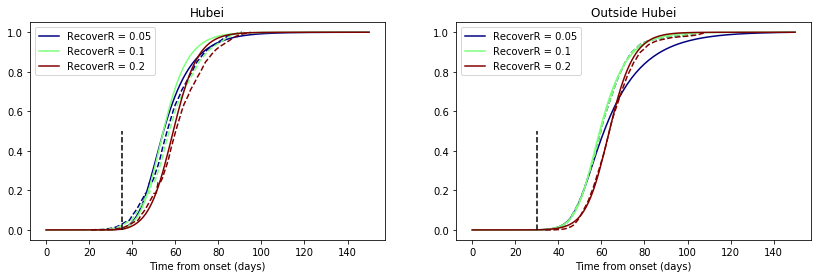

In [25]:
ii = 0
results = np.zeros((len(t), 4))
fig = plt.figure(figsize = (14, 4))  
plt.subplot(121)
alpha = 0.2
beta = 3
gamma = 0.1
delta = 0.04
N = 58500000
M = 1
rho = 0.3

Delay_quarantine = 35
Recover_1 = df.iloc[2, 2:].values
Recover_2 = df.iloc[5, 2:].values
for gamma in [0.05, 0.1, 0.2]:
    params = alpha, beta, gamma, delta, rho 
    init_vals = 1 - M/N, M/N, 0, 0
    # Run simulation    
    results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)      
    plt.plot(results[:,3]/max(results[:,3]),color = colors[ii], label= 'RecoverR = ' +  str(gamma))
    Hubei = Recover_2/max(Recover_2)  
    peak_loc = np.argmin(abs(results[:,3]/max(results[:,3])-0.2))    
    peak_loc_hubei = np.argmin(abs(Hubei-0.2))    
    delay1 = peak_loc - peak_loc_hubei    
    #print(delay1)
    xx= list(range(len(Hubei)))    
    xx_delay = list(map(lambda x:x + delay1, xx)) 
    plt.plot(xx_delay, Hubei,color = colors[ii], linestyle = '--')
    ii += 1    
plt.plot([Delay_quarantine, Delay_quarantine],[0, 0.5], 'k--')
plt.legend()
plt.title('Hubei')
plt.xlabel('Time from onset (days)')

alpha = 0.2
gamma = 0.1
delta = 0.01
N = 1000000000
M = 1

Delay_quarantine = 30
plt.subplot(122)
ii = 0
for gamma in [0.05, 0.1, 0.2]:
    params = alpha, beta, gamma, delta, rho       
    # Run simulation  
    results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)    
    plt.plot(results[:,3]/max(results[:,3]),color = colors[ii], label = 'RecoverR = ' + str(gamma))
    Non_Hubei = Recover_1/max(Recover_1)    
    peak_loc = np.argmin(abs(results[:,3]/max(results[:,3])-0.2))    
    peak_loc_non_hubei = np.argmin(abs(Non_Hubei-0.2))    
    delay2 = peak_loc - peak_loc_non_hubei    
    
    xx= list(range(len(Non_Hubei)))        
    xx_delay = list(map(lambda x:x + delay2, xx))
    plt.plot(xx_delay, Non_Hubei,color = colors[ii], linestyle = '--')
    ii += 1
    
plt.legend()
plt.plot([Delay_quarantine, Delay_quarantine],[0, 0.5], 'k--')
plt.title('Outside Hubei')
plt.xlabel('Time from onset (days)')


18
17
15


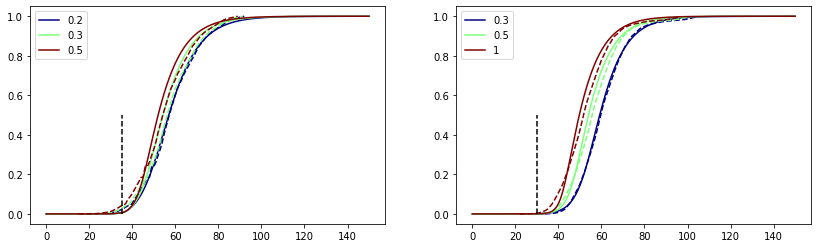

In [30]:
ii = 0
results = np.zeros((len(t), 4))
fig = plt.figure(figsize = (14, 4))  
plt.subplot(121)
alpha = 0.2
beta = 3
N = 58500000
M = 1
rho = 0.3

gamma = 0.05
delta = 0.05

Delay_quarantine = 35
Recover_1 = df.iloc[2, 2:].values
Recover_2 = df.iloc[5, 2:].values
for rho in [0.2, 0.3, 0.5]:
    params = alpha, beta, gamma, delta, rho 
    init_vals = 1 - M/N, M/N, 0, 0
    # Run simulation    
    results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)      
    plt.plot(results[:,3]/max(results[:,3]),color = colors[ii], label= str(rho))
    Hubei = Recover_2/max(Recover_2)  
    peak_loc = np.argmin(abs(results[:,3]/max(results[:,3])-0.2))    
    peak_loc_hubei = np.argmin(abs(Hubei-0.2))    
    delay1 = peak_loc - peak_loc_hubei    
    print(delay1)
    xx= list(range(len(Hubei)))    
    xx_delay = list(map(lambda x:x + delay1, xx)) 
    plt.plot(xx_delay, Hubei,color = colors[ii], linestyle = '--')
    ii += 1    
plt.plot([Delay_quarantine, Delay_quarantine],[0, 0.5], 'k--')
plt.legend()


gamma = 0.1
delta = 0.01
N = 1000000000
M = 10

Delay_quarantine = 30
plt.subplot(122)
ii = 0
for rho in [0.3, 0.5, 1]:
    params = alpha, beta, gamma, delta, rho       
    # Run simulation  
    results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)    
    plt.plot(results[:,3]/max(results[:,3]),color = colors[ii], label = str(rho))
    Non_Hubei = Recover_1/max(Recover_1)    
    peak_loc = np.argmin(abs(results[:,3]/max(results[:,3])-0.2))    
    peak_loc_non_hubei = np.argmin(abs(Non_Hubei-0.2))    
    delay2 = peak_loc - peak_loc_non_hubei    
    
    xx= list(range(len(Non_Hubei)))        
    xx_delay = list(map(lambda x:x + delay2, xx))
    plt.plot(xx_delay, Non_Hubei,color = colors[ii], linestyle = '--')
    ii += 1
    
plt.legend()
plt.plot([Delay_quarantine, Delay_quarantine],[0, 0.5], 'k--')


Text(0.5, 1.0, 'Fitting for China data')

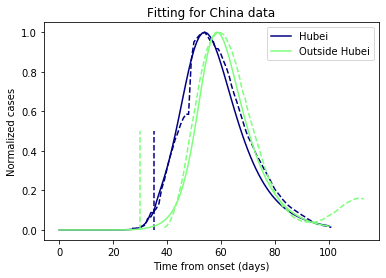

In [34]:
# compare the fitting results with the parameter we got before
t_max = 100
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
alpha = 0.2
gamma = 0.05
delta = 0.05
rho = 0.2
beta = 3
Delay_quarantine = 35
N = 58500000
M = 1

results = np.zeros((101, 4))
#fig = plt.figure(figsize = (14, 4))  

params = alpha, beta, gamma, delta, rho  
init_vals = 1 - M/N, M/N, 0, 0
# Run simulation    
results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)      
Hubei = Active2/max(Active2)
peak_loc = np.argmax(results[:,2])    
peak_loc_hubei = np.argmax(Hubei)
xx= list(range(len(Hubei)))
delay1 = peak_loc - peak_loc_hubei
xx_delay = list(map(lambda x:x + delay1, xx))
plt.plot(results[:,2]/max(results[:,2]), color = colors[0], label ='Hubei' )   
plt.plot(xx_delay, Hubei, color = colors[0],linestyle = '--')       
plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.5], color = colors[0],linestyle = '--') 



N = 1000000000
M = 10
rho = 0.3
delta = 0.01 #death rate
gamma = 0.1 # recover rate
Delay_quarantine = 30

params = alpha, beta, gamma, delta, rho   
init_vals = 1 - M/N, M/N, 0, 0
# Run simulation  
results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)
peak_loc = np.argmax(results[:,2])    
Non_Hubei = Active1/max(Active1)
peak_loc_non_hubei = np.argmax(Non_Hubei)
xx= list(range(len(Non_Hubei)))
delay2 = peak_loc - peak_loc_non_hubei
xx_delay = list(map(lambda x:x + delay2, xx))
plt.plot(results[:,2]/max(results[:,2]), color = colors[1], label ='Outside Hubei' ) 
plt.plot(xx_delay, Non_Hubei, color = colors[1],linestyle = '--')
    
plt.legend()
plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.5], color = colors[1],linestyle = '--')
plt.ylabel('Normalized cases')
plt.xlabel('Time from onset (days)')
plt.title('Fitting for China data')

In [146]:
path1 = r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv'
path2 = r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_global.csv'
path3 = r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_recovered_global.csv'

Confirmed = pd.read_csv(path1,encoding = "ISO-8859-1", error_bad_lines=False)
Deaths = pd.read_csv(path2,encoding = "ISO-8859-1", error_bad_lines=False)
Recovered = pd.read_csv(path3,encoding = "ISO-8859-1", error_bad_lines=False)
#Confirmed.info()


In [72]:
import math
def select_high_risk_country(threshold = [50000]):
    all_countries = set(Confirmed['Country/Region'])
    high_risk_country = []
    tt = np.empty(2)
    tt[0] = threshold[0]
    if len(threshold) == 1:        
        tt[1] = math.inf
    else:
        tt[1] = threshold[1]    
    for country in all_countries:        
        ctr_data = Confirmed.loc[(Confirmed['Country/Region'] == country)].values
        ctr_sum = ctr_data[:,-1].sum(axis = 0)        
        if (ctr_sum >= tt[0]) & (ctr_sum <= tt[1]):            
            high_risk_country.append(country)                           
    return high_risk_country

C:\Users\chrji\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


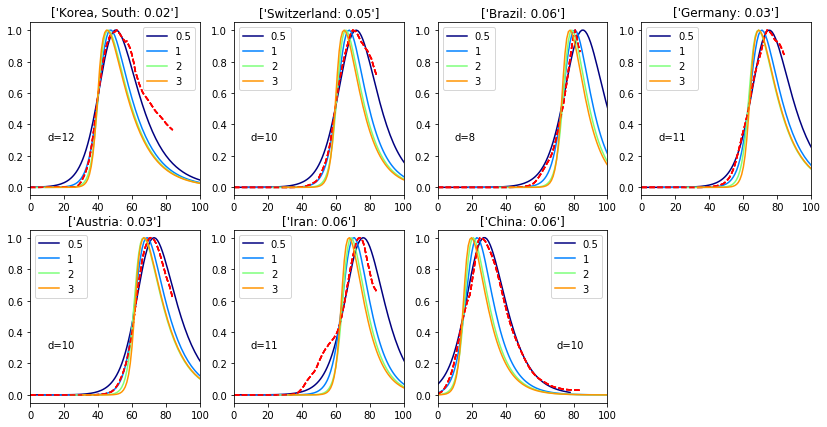

In [131]:
alpha = 0.2
beta = 3
gamma = 0.05
delta = 0.1
N = 1e7
M = 10
rho = 1

t_max = 150
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
    
Delay_quarantine = 35   

countrys = select_high_risk_country([9000])
number_of_lines = 5
cm_subsection = linspace(0, 1, number_of_lines) 
colors = [plt.cm.jet(x) for x in cm_subsection]

ii = 1
fig = plt.figure(figsize = (14, 7))  
for country in countrys:
    plt.subplot(2,4,ii)
    region_confirm = Confirmed.loc[(Confirmed['Country/Region'] == country)].values[:,4:].sum(axis = 0)
    region_death = Deaths.loc[(Deaths['Country/Region'] == country)].values[:,4:].sum(axis = 0)
    region_recovered = Recovered.loc[(Recovered['Country/Region'] == country)].values[:,4:].sum(axis = 0)
    delta = region_death[-1]/region_confirm[-1] # death rate
    Active = (region_confirm - region_death - region_recovered)
    Active = np.convolve(Active, [0.2]*5, 'same')
    diff_active = Active[1:-2]-Active[:-3]
    peak_diff_loc = np.argmax(diff_active)    
    
    if min(diff_active[peak_diff_loc:]) <= 0:        
        Active_case = Active/max(Active)
        # Run simulation
        init_vals = 1 - M/N, M/N, 0, 0  
        num = 0
        for beta in [0.5, 1, 2, 3]:
            params = alpha, beta, gamma, delta, rho              
            #results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine) 
            results = seir_model_with_soc_dist(init_vals, params, t)
            infec_case = results[:,2]/max(results[:,2])   #+results[:,3]                            
            
            model_peak = np.argmax(infec_case)       
            data_peak = np.argmax(Active_case)    
            model_half = np.argmin(abs(infec_case[:model_peak]-0.5))       
            data_half = np.argmin(abs(Active_case[:data_peak]-0.5))    
            delay =  data_half-model_half
            day_2_peak = data_peak-data_half
            xx= list(range(len(Active))) 

            plt.plot(xx[:-2],Active_case[:-2] , color = [1, 0, 0], linestyle = '--')
            xx_delay = list(map(lambda x:x + delay, t))
            plt.plot(xx_delay, infec_case,color = colors[num], label = str(beta))
            num += 1
            plt.title([country + ': ' + format(delta, '.2f')])
        #plt.plot([peak_diff_loc,peak_diff_loc],[0,1],linestyle = '--')
        if data_half>20:
            plt.text(10,0.3,'d='+str(day_2_peak))
        else:
            plt.text(70,0.3,'d='+str(day_2_peak))
        
        plt.legend()
        plt.xlim([0, 100])
        ii += 1



Based on this simulation, countries that already passed their peaks tend to follow a curve of $\beta = 0.5$ or 1. If we assume the basic $\beta$ value is 3, then this countries should present a social distancing with $\rho = 0.17$ to 0.3. It takes 10 to 13 days from the half peak to peak. We can then measure the slope of half peak and use it to predict when the other countries can reach their peaks.

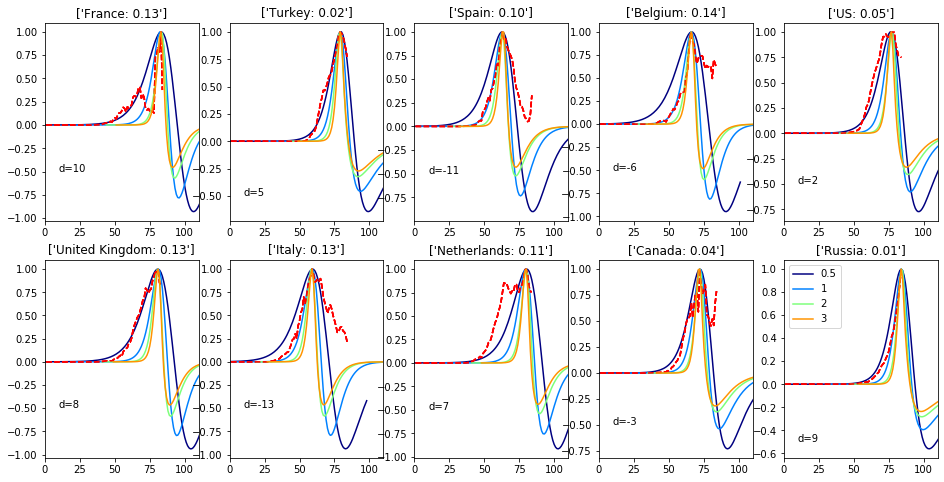

In [144]:
countrys = select_high_risk_country([30000])
fig = plt.figure(figsize = (16, 8)) 
ii = 1
for country in countrys:    
    region_confirm = Confirmed.loc[(Confirmed['Country/Region'] == country)].values[:,4:].sum(axis = 0)
    region_death = Deaths.loc[(Deaths['Country/Region'] == country)].values[:,4:].sum(axis = 0)
    region_recovered = Recovered.loc[(Recovered['Country/Region'] == country)].values[:,4:].sum(axis = 0)
    delta = region_death[-1]/region_confirm[-1] # death rate
    
    Active = (region_confirm - region_death - region_recovered)
    Active = np.convolve(Active, [0.2]*5, 'same')
    diff_active = Active[1:-2]-Active[:-3]
    peak_diff_loc = np.argmax(diff_active)    
    
    if min(diff_active[peak_diff_loc:]) > 0: 
        plt.subplot(2,5,ii)
        # Run simulation
        init_vals = 1 - M/N, M/N, 0, 0 
        diff_active = diff_active/max(diff_active)
        num = 0
        for beta in [0.5, 1, 2, 3]:
            params = alpha, beta, gamma, delta, rho              
            #results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine) 
            results = seir_model_with_soc_dist(init_vals, params, t)
            infec_case = results[:,2]  #+results[:,3]                            
            diff_infec = infec_case[1:] - infec_case[:-1]
            diff_infec = diff_infec/max(diff_infec)
            
            model_peak = np.argmax(diff_infec)       
            data_peak = np.argmax(diff_active)    
            #model_half = np.argmin(abs(infec_case[:model_peak]-0.5))       
            #data_half = np.argmin(abs(Active_case[:data_peak]-0.5))    
            delay = data_peak-model_peak
            if beta == 0.5:
                day_2_peak = np.argmax(infec_case) + delay - len(diff_active)
            
            xx= list(range(len(Active))) 
            plt.plot(xx[1:-2],diff_active, color = [1, 0, 0], linestyle = '--')
            xx_delay = list(map(lambda x:x + delay, t))
            plt.plot(xx_delay[1:], diff_infec,color = colors[num], label = str(beta))
            num += 1
            plt.title([country + ': ' + format(delta, '.2f')])        
        plt.text(10, -0.5 ,'d='+str(day_2_peak))        
        plt.xlim([0, 110])
        ii += 1
plt.legend()


In [40]:
import os
import tarfile

path_state = r'C:\Users\chrji\Documents\GitHub\COVIDExposureIndices\lex_data\state_lex_2020-03-27.csv'
state_lex = pd.read_csv(path_state,encoding = "ISO-8859-1", error_bad_lines=False)

path1 = r'C:\Users\chrji\Downloads\states-daily.csv'
path2 = r'C:\Users\chrji\Downloads\states-info.csv'

state_daily = pd.read_csv(path1,encoding = "ISO-8859-1", error_bad_lines=False)
state_info = pd.read_csv(path2,encoding = "ISO-8859-1", error_bad_lines=False)

path1 = r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_US.csv'
path2 = r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_US.csv'

state_data = pd.read_csv(path1,encoding = "ISO-8859-1", error_bad_lines=False)
state_death = pd.read_csv(path2,encoding = "ISO-8859-1", error_bad_lines=False)
state_data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,121,128,130,133,133,133,133,135,135,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,11,11,11,11,11,11,11,13,13,13
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,620,683,725,788,897,903,923,974,1043,1068
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,45,45,50,51,51,51,51,51,51,51


In [41]:
import os
os.environ["PROJ_LIB"] = "C:\\Users\\chrji\\Anaconda3\\Library\\share"; 

import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

%matplotlib inline

def add_colorbar(ax, aspect = 20, pad_fraction = 0.5, labelname = 'Case numbers'):        
        divider = make_axes_locatable(ax)
        width = axes_size.AxesY(ax, aspect=1./aspect)
        pad = axes_size.Fraction(pad_fraction, width)
        cax = divider.append_axes("right", size=width, pad=pad)
        cbar = plt.colorbar(label = labelname, cax=cax,ticks=[0,1,2,3,4,5])
        return cbar

def plot_daily_map(date = '3/14/20'):
    ax = plt.gca()
    # get the raw map of region
    region_data = state_data
    #BBox = (region_data.Lat.min()-10, region_data.Lat.max()+10, region_data.Long_.min()-10, region_data.Long_.max()+10)  
    BBox = [20, 56, -130,-60]
    #print(BBox)
    m = Basemap(resolution='l', # c for crude, l for low, i for intermediate, h for high, f for full or None
                projection='merc',
                #lat_0=40, lon_0=-110,
                llcrnrlon=BBox[2], llcrnrlat= BBox[0], urcrnrlon=BBox[3] , urcrnrlat=BBox[1])

    m.drawmapboundary(fill_color='#A6CAE0', linewidth = 0)
    m.fillcontinents(color='grey',alpha = 0.3, lake_color='#A6CAE0')
    m.drawcoastlines(linewidth=0.2, color="white")
    m.drawcountries(color = 'white')

    # plot the scatter points of case numbers above the map, color indicate the numbers
    lon = region_data['Long_'].values
    lat = region_data['Lat'].values
    cases = region_data[date].values
    idx = cases>0
    m.scatter(lon[idx], lat[idx], latlon=True,
              c=np.log10(cases[idx]),
              cmap='RdBu_r', alpha=0.8)
    plt.clim(0, 3.8)
    plt.title('Covid Cases in {} on {}'.format('US', date))
    cbar = add_colorbar(ax)
    cbar.ax.set_yticklabels(['1','10','100','1000','10000'])
    return region_data
    # set the location and size of colorbar
    

C:\Users\chrji\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\chrji\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


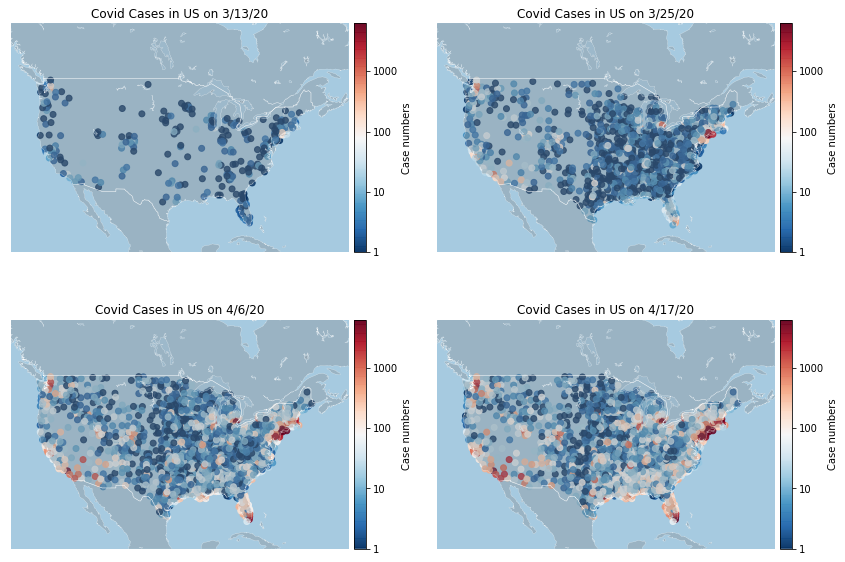

In [42]:
# plot the latest distribution of cases
fig = plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
region_data = plot_daily_map(date = state_data.columns[-36])  #, region = 'China'
plt.subplot(2,2,2)
region_data = plot_daily_map(date = state_data.columns[-24])  #, region = 'China'
plt.subplot(2,2,3)
region_data = plot_daily_map(date = state_data.columns[-12])  #, region = 'China'
plt.subplot(2,2,4) 
region_data = plot_daily_map(date = state_data.columns[-1])  #, region = 'China'


In [43]:
states_in_lex = state_lex.columns
dates = state_daily['date']
state_latest = state_daily.loc[(state_daily['date'] == dates[0])]
state_latest_new = state_latest.sort_values(by = 'positive', ascending = False)
pos_case=np.zeros(len(states_in_lex)-1)
ii=0
for state in states_in_lex[1:]:
    pos_case[ii] = state_latest.loc[(state_latest['state'] == state)]['positive'].values 
    ii += 1

In [147]:
#state_latest_new.head(5)

Text(0, 0.5, 'LEX index')

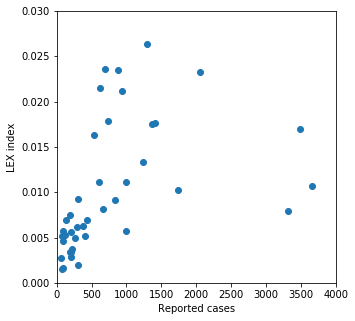

In [45]:
lex_index = state_lex['NY'] + state_lex['CA'] + state_lex['FL'] + state_lex['WA']
fig = plt.figure(figsize=(5, 5))
plt.scatter(pos_case, lex_index)

plt.xlim(0, 4000)
plt.ylim(0,0.03)
plt.xlabel('Reported cases')
plt.ylabel('LEX index')

In [46]:
# to be finish
def safety_index(zipcode = '07052', age = 25):  
    path1 = r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_US.csv'
    path2 = r'C:\Users\chrji\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_US.csv'

    state_data = pd.read_csv(path1,encoding = "ISO-8859-1", error_bad_lines=False)
    lat_0, long_0 = 30, -100 
    lon = state_data['Long_'].values
    lat = state_data['Lat'].values
        
    lex_index = (state_lex['NY'] + state_lex['CA'] + state_lex['FL'])/3
    
    risky_group_ratio = 0.15 # change by zipcode
    local_density = 0.9 # china is 1
    t_max = 100
    Delay_quarantine = 10
    dt = 1
    t = np.linspace(0, t_max, int(t_max/dt) + 1)
    N = 8000000  # get by zipcode
    M = 1
    alpha = 0.2 # 1/incubation period, 5.1 days (95% CI, 4.5 to 5.8 days),
    beta = 3 * local_density  # spreading rate 
    gamma = 0.1 # recovery rate
    rho = 0.5    
    delta = 0.01 * (1-risky_group_ratio) + risky_group_ratio * 0.1 # death rate, 0.01 for younger group, but over 0.1 for eldly group
    HealthCare_need = 0.2 * (1-risky_group_ratio) + risky_group_ratio * 0.7
    Delay_quarantine = 30 
    
    params = alpha, beta, gamma, delta, rho      
    init_vals = 1 - M/N, M/N, 0, 0   
    results = seir_delay_soc_dist(init_vals, params, t, Delay_quarantine)
    days_onset = 40
    
    peak = np.argmax(results[:,2])
    xx= list(range(len(results[:,2])))
    plt.plot(xx,results[:,2]/max(results[:,2]))
    plt.plot([Delay_quarantine,Delay_quarantine],[0, 0.7],linestyle = '--')
    plt.text(Delay_quarantine-5, 0.75, 'SD start')
    plt.plot(days_onset,results[days_onset,2]/max(results[:,2]),marker = '*')
    plt.text(days_onset-5, 0.65, 'You are here')
    plt.xlabel('Days from case emergence')
    
    
    print('Risk at your location is: {}'.format(results[days_onset,1]))
    print('Risk at your age is: {}'.format(results[days_onset,1]*0.5))

safety_index(zipcode= '07052')       

